# Sentiment Per Location 
Based on: https://datascience.quantecon.org/applications/maps.html <br>
Info on geopy: https://geopy.readthedocs.io/en/stable/

In [3]:
# pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
from shapely.geometry import Point
import os
import sys
import csv
import geopandas as gpd
from geopy import geocoders
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Basic paths
project_path = Path().resolve().parent
csv_path = project_path / "speeches_csv"

In [3]:
# Open in pandas the table with the sentiment and the location information
df_sen = pd.read_csv("results_sa_all.txt") #Make sure to update this data
df_sen.head()

,title,date,stanza,textblob,vader,subjectivity
0,Prayer_Breakfast_2016,2016-02-04,0.099,0.178,1.000,0.542
1,Security_Team_Announcement,2008-12-01,0.140,0.162,0.998,0.403
2,Cairo_University,2009-06-04,-0.150,0.110,1.000,0.457
3,Umpqua_Community_College_Shootings,2015-10-01,-0.250,0.061,-0.998,0.435
4,White_House_Correspondent_Dinner_2013,2013-04-27,-0.012,0.145,1.000,0.501


In [4]:
# Call the all_speechs dataframe and clean it a bit
df_temp = pd.read_csv(csv_path / "all_speeches_cleaned.txt") 
df_temp = df_temp.drop(columns=["count_commas","content","date"]) # I un-dropped "location".
df_temp = df_temp[ df_temp["highest_speaker_count"] <= 3 ]
df_temp.head()

,title,pages,location,highest_speaker_count,country,state,city,specific_location
1,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton
2,Security_Team_Announcement,5,"Chicago, Illinois",0,USA,Illinois,Chicago,no_specific_location
3,Cairo_University,14,"Cairo, Egypt",0,Egypt,no_state,Cairo,no_specific_location
4,Umpqua_Community_College_Shootings,4,Washington D.C.,0,USA,no_state,Washington D.C.,no_specific_location
5,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton Hotel


In [5]:
# Merge the previous tables
df_cb = pd.merge(df_temp, df_sen, how='inner', on = 'title')
df_cb.head()

,title,pages,location,highest_speaker_count,country,state,city,specific_location,date,stanza,textblob,vader,subjectivity
0,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542
1,Security_Team_Announcement,5,"Chicago, Illinois",0,USA,Illinois,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403
2,Cairo_University,14,"Cairo, Egypt",0,Egypt,no_state,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457
3,Umpqua_Community_College_Shootings,4,Washington D.C.,0,USA,no_state,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435
4,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501


# Get Coordinates of the City Names

In [6]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="seorin_kim")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_cb['geo_location'] = df_cb['location'].apply(geocode)

df_cb['point'] = df_cb['geo_location'].apply(lambda loc: tuple(loc.point) if loc else None)
# Point = (latitude, longitude)

df_cb.head()
    

,title,pages,location,highest_speaker_count,country,state,city,specific_location,date,stanza,textblob,vader,subjectivity,geo_location,point
0,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)"
1,Security_Team_Announcement,5,"Chicago, Illinois",0,USA,Illinois,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)"
2,Cairo_University,14,"Cairo, Egypt",0,Egypt,no_state,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)"
3,Umpqua_Community_College_Shootings,4,Washington D.C.,0,USA,no_state,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)"
4,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)"


In [7]:
df_cb['geo_location'][0].raw.keys()

dict_keys(['place_id', 'licence', 'osm_type', 'osm_id', 'boundingbox', 'lat', 'lon', 'display_name', 'class', 'type', 'importance', 'icon'])

In [8]:
df_cb['latitude'] = df_cb['geo_location'].apply(lambda loc: loc.raw['lat'] if loc else None)
df_cb['longitude'] = df_cb['geo_location'].apply(lambda loc: loc.raw['lon'] if loc else None)
df_cb.dtypes

title                     object
pages                      int64
location                  object
highest_speaker_count      int64
country                   object
state                     object
city                      object
specific_location         object
date                      object
stanza                   float64
textblob                 float64
vader                    float64
subjectivity             float64
geo_location              object
point                     object
latitude                  object
longitude                 object
dtype: object

In [9]:
df_cb['latitude'] = pd.to_numeric(df_cb['latitude'])
df_cb['longitude'] = pd.to_numeric(df_cb['longitude'])
df_cb["Coordinates"] = list(zip(df_cb.longitude, df_cb.latitude))
df_cb.dtypes

title                     object
pages                      int64
location                  object
highest_speaker_count      int64
country                   object
state                     object
city                      object
specific_location         object
date                      object
stanza                   float64
textblob                 float64
vader                    float64
subjectivity             float64
geo_location              object
point                     object
latitude                 float64
longitude                float64
Coordinates               object
dtype: object

In [10]:
from shapely.geometry import Point
df_cb["geometry"] = df_cb["Coordinates"].apply(Point)
df_cb.head()

,title,pages,location,highest_speaker_count,country,state,city,specific_location,date,stanza,textblob,vader,subjectivity,geo_location,point,latitude,longitude,Coordinates,geometry
0,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.0452084 38.9165229)
1,Security_Team_Announcement,5,"Chicago, Illinois",0,USA,Illinois,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)",41.875562,-87.624421,"(-87.6244212, 41.8755616)",POINT (-87.6244212 41.8755616)
2,Cairo_University,14,"Cairo, Egypt",0,Egypt,no_state,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)",30.044388,31.235726,"(31.2357257, 30.0443879)",POINT (31.2357257 30.0443879)
3,Umpqua_Community_College_Shootings,4,Washington D.C.,0,USA,no_state,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)",38.895037,-77.036543,"(-77.0365427, 38.8950368)",POINT (-77.0365427 38.8950368)
4,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,USA,no_state,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.0452084 38.9165229)


In [11]:
df_cb['country'] = df_cb['country'].replace(['USA'], 'United States of America')
df_cb['country']

0      United States of America
1      United States of America
2                         Egypt
3      United States of America
4      United States of America
                 ...           
341                      Israel
342                    Malaysia
343    United States of America
344    United States of America
345    United States of America
Name: country, Length: 346, dtype: object

In [12]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
# To see Per Country
df_w_wrld = df_cb.merge(world, left_on = 'country', right_on='name', how='inner')
df_w_wrld = df_w_wrld.drop(columns = 'geometry_x')
df_w_wrld.rename(columns = {'geometry_y' : 'geometry'}, inplace = True)

gdf_cntry = gpd.GeoDataFrame(df_w_wrld, crs="EPSG:4326")
gdf_cntry.head()

,title,pages,location,highest_speaker_count,country,state,city,specific_location,date,stanza,...,geo_location,point,latitude,longitude,Coordinates,pop_est,continent,name,gdp_md_est,geometry
0,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,United States of America,no_state,Washington D.C.,Washington Hilton,2016-02-04,0.099,...,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
1,Security_Team_Announcement,5,"Chicago, Illinois",0,United States of America,Illinois,Chicago,no_specific_location,2008-12-01,0.140,...,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)",41.875562,-87.624421,"(-87.6244212, 41.8755616)",326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
2,Umpqua_Community_College_Shootings,4,Washington D.C.,0,United States of America,no_state,Washington D.C.,no_specific_location,2015-10-01,-0.250,...,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)",38.895037,-77.036543,"(-77.0365427, 38.8950368)",326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
3,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,United States of America,no_state,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,...,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
4,Border_Security_and_Immigration_Reform,5,unknown_location,0,United States of America,no_state,Washington D.C.,White House,2014-06-30,-0.177,...,"(unknown, Gachoire Kiawambe, Nyanduma Sub Loc...","(-0.9999454, 36.7416612, 0.0)",-0.999945,36.741661,"(36.7416612, -0.9999454)",326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [14]:
gdf = gpd.GeoDataFrame(df_cb, crs="EPSG:4326")
gdf

,title,pages,location,highest_speaker_count,country,state,city,specific_location,date,stanza,textblob,vader,subjectivity,geo_location,point,latitude,longitude,Coordinates,geometry
0,Prayer_Breakfast_2016,7,"Washington Hilton, Washington D.C.",0,United States of America,no_state,Washington D.C.,Washington Hilton,2016-02-04,0.099,0.178,1.000,0.542,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.04521 38.91652)
1,Security_Team_Announcement,5,"Chicago, Illinois",0,United States of America,Illinois,Chicago,no_specific_location,2008-12-01,0.140,0.162,0.998,0.403,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)",41.875562,-87.624421,"(-87.6244212, 41.8755616)",POINT (-87.62442 41.87556)
2,Cairo_University,14,"Cairo, Egypt",0,Egypt,no_state,Cairo,no_specific_location,2009-06-04,-0.150,0.110,1.000,0.457,"(القاهرة, 11519, مصر, (30.0443879, 31.2357257))","(30.0443879, 31.2357257, 0.0)",30.044388,31.235726,"(31.2357257, 30.0443879)",POINT (31.23573 30.04439)
3,Umpqua_Community_College_Shootings,4,Washington D.C.,0,United States of America,no_state,Washington D.C.,no_specific_location,2015-10-01,-0.250,0.061,-0.998,0.435,"(Washington, District of Columbia, United Stat...","(38.8950368, -77.0365427, 0.0)",38.895037,-77.036543,"(-77.0365427, 38.8950368)",POINT (-77.03654 38.89504)
4,White_House_Correspondent_Dinner_2013,6,"Washington Hilton Hotel, Washington D.C.",0,United States of America,no_state,Washington D.C.,Washington Hilton Hotel,2013-04-27,-0.012,0.145,1.000,0.501,"(Washington Hilton, 1919, Connecticut Avenue N...","(38.9165229, -77.0452084, 0.0)",38.916523,-77.045208,"(-77.0452084, 38.9165229)",POINT (-77.04521 38.91652)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Shimon_Peres_Memorial,6,"Mount Herzl, Jerusalem, Israel",0,Israel,no_state,Jerusalem,Mount Herzl,2016-09-30,-0.083,0.164,1.000,0.436,"(הר הרצל, הזיכרון, יפה נוף, ירושלים, נפת ירושל...","(31.772361150000002, 35.181634190650314, 0.0)",31.772361,35.181634,"(35.181634190650314, 31.77236115)",POINT (35.18163 31.77236)
342,ASEAN_Business_2015,9,"Shangri-La Hotel, Kuala Lumpur, Malaysia",0,Malaysia,no_state,Kuala Lumpur,Shangri-La Hotel,2015-11-21,-0.050,0.164,1.000,0.399,"(Shangri-La Hotel, 11, Jalan Sultan Ismail, Bu...","(3.1541698, 101.7064587, 0.0)",3.154170,101.706459,"(101.7064587, 3.1541698)",POINT (101.70646 3.15417)
343,Finance_Crisis_Fee,3,unknown_location,0,United States of America,no_state,Washington D.C.,White House,2010-01-14,-0.412,0.080,0.987,0.436,"(unknown, Gachoire Kiawambe, Nyanduma Sub Loc...","(-0.9999454, 36.7416612, 0.0)",-0.999945,36.741661,"(36.7416612, -0.9999454)",POINT (36.74166 -0.99995)
344,Oval_Office_Counter_Terrorism_Agenda,5,"White House, Washington D.C.",0,United States of America,no_state,Washington D.C.,White House,2015-12-06,-0.134,0.076,-1.000,0.398,"(White House, 1600, Pennsylvania Avenue Northw...","(38.897699700000004, -77.03655315, 0.0)",38.897700,-77.036553,"(-77.03655315, 38.8976997)",POINT (-77.03655 38.89770)


# Where Were the Speeches?

Tried it with plotly! It looks much neater!
https://plotly.com/python/scatter-plots-on-maps/

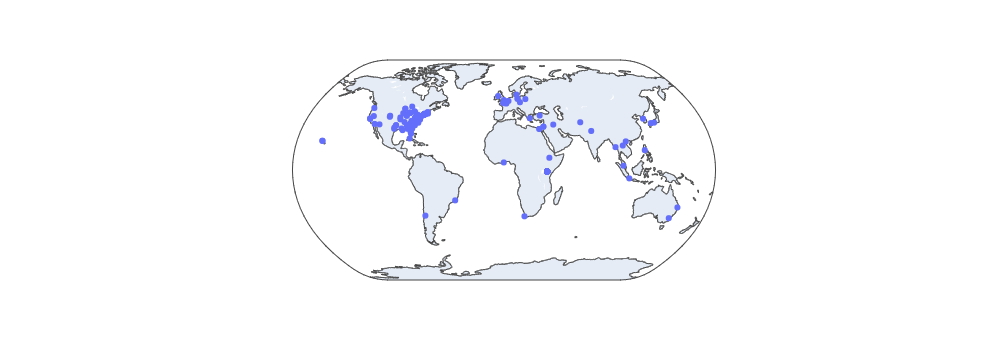

In [42]:

import plotly.express as px
# df = px.data.gapminder().query("year==2007")
fig = px.scatter_geo(gdf, lat="latitude", lon="longitude", 
                      hover_name="title", 
                     hover_data= ["location","textblob"],
                     projection="natural earth")
fig.show()

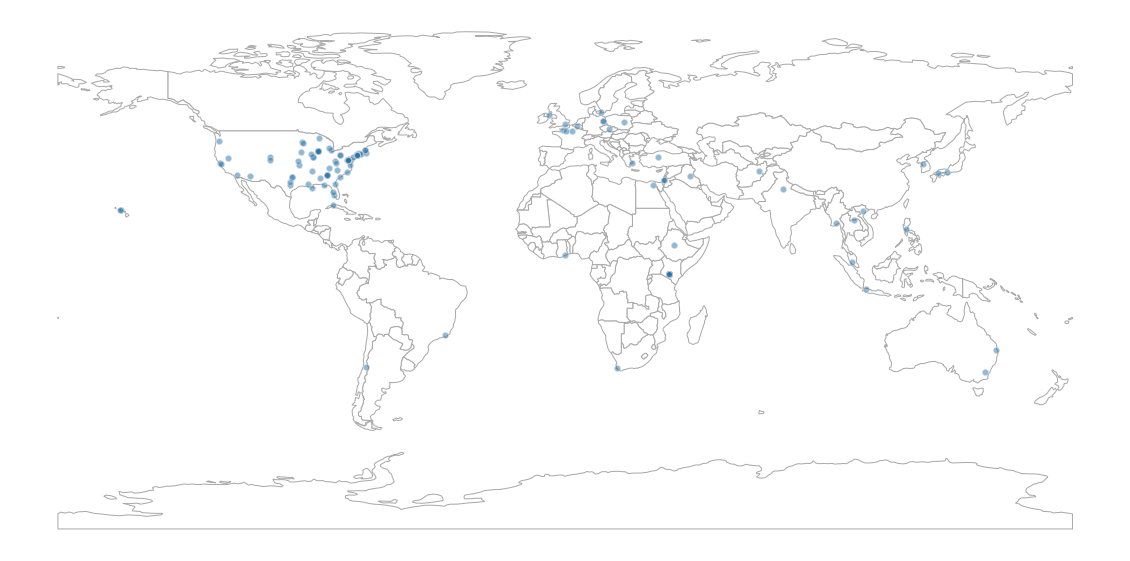

In [15]:
fig, gax = plt.subplots(figsize = (20,20))

# Plot the world map
world.plot(ax = gax, edgecolor='darkgray',color='white')

gdf.plot(
    ax=gax, edgecolor='lightgray', legend=True, alpha=0.5 )

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

# Sentiments Per Country

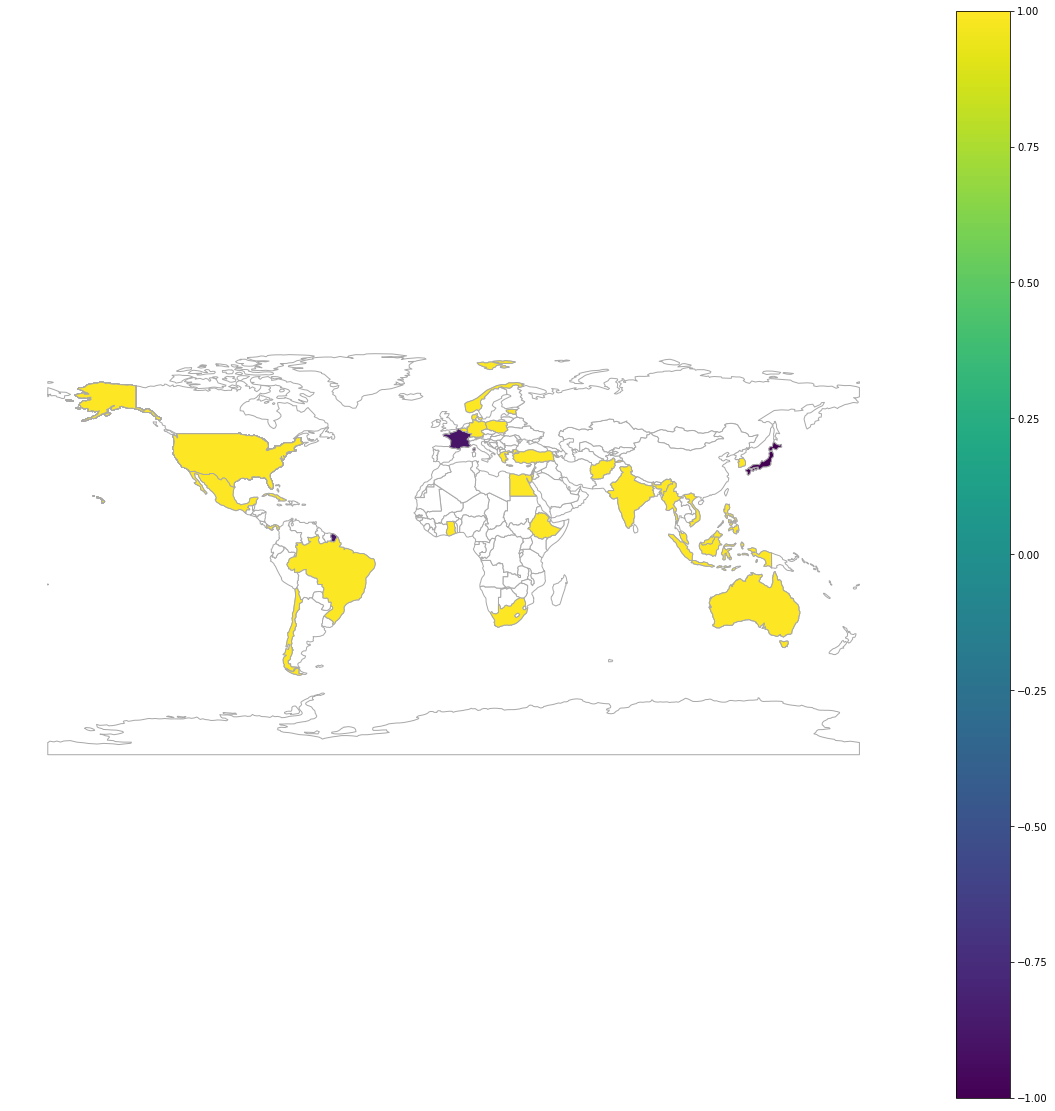

In [16]:
fig, gax = plt.subplots(figsize = (20,20))

# Plot the world map
world.plot(ax = gax, edgecolor='darkgray',color='white')

gdf_cntry.plot(
    ax=gax, edgecolor='darkgray', column='vader', legend=True, cmap='viridis' #if not 'vader' there's no color difference.
)

# I don't want the axis with long and lat
plt.axis('off')

plt.show()

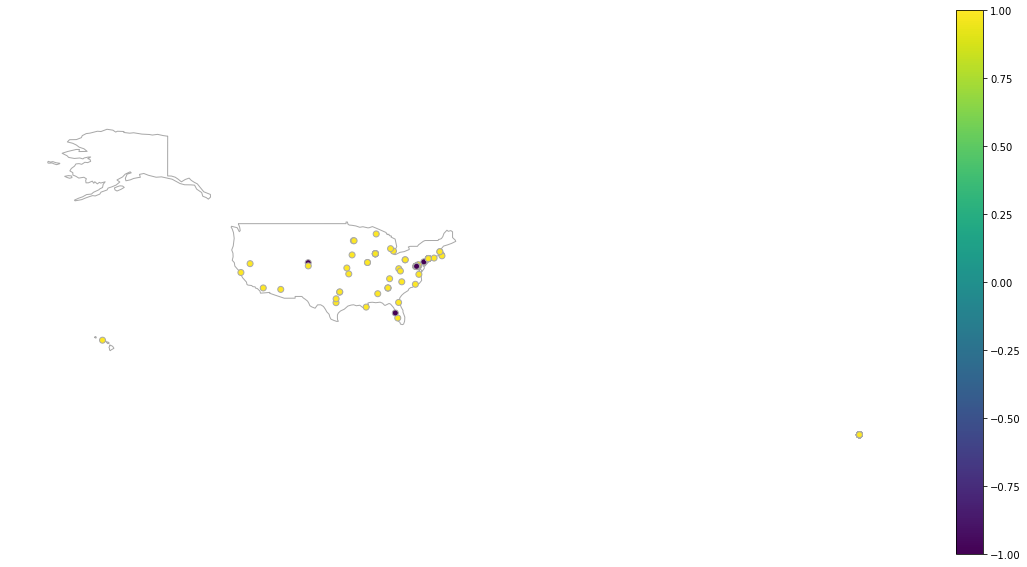

In [17]:
usa = world[world['name'] =='United States of America']

fig, gax = plt.subplots(figsize = (20,10))

# Plot the state
usa.plot(ax = gax, edgecolor='darkgray',color='white')

# Plot the counties and pass 'rel_trump_share' as the data to color
gdf[gdf['country'] == 'United States of America'].plot(
    ax=gax, edgecolor='darkgray', column='vader', legend=True, cmap='viridis')
# I don't want the axis with long and lat
plt.axis('off')

plt.show()

In [ ]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json

Loading BokehJS ...

In [ ]:
gdf_simple = gdf.drop(columns = ['pages', 'highest_speaker_count', 'country', 'state', 'city', 'specific_location', 'geo_location', 'point', 'Coordinates', 'latitude', 'longitude'])
gdf_simple

,title,location,date,stanza,textblob,vader,subjectivity,geometry
0,Prayer_Breakfast_2016,"Washington Hilton, Washington D.C.",2016-02-04,0.099,0.178,1.000,0.542,POINT (-77.04521 38.91652)
1,Security_Team_Announcement,"Chicago, Illinois",2008-12-01,0.140,0.162,0.998,0.403,POINT (-87.62442 41.87556)
2,Cairo_University,"Cairo, Egypt",2009-06-04,-0.150,0.110,1.000,0.457,POINT (31.23573 30.04439)
3,Umpqua_Community_College_Shootings,Washington D.C.,2015-10-01,-0.250,0.061,-0.998,0.435,POINT (-77.03654 38.89504)
4,White_House_Correspondent_Dinner_2013,"Washington Hilton Hotel, Washington D.C.",2013-04-27,-0.012,0.145,1.000,0.501,POINT (-77.04521 38.91652)
...,...,...,...,...,...,...,...,...
283,Shimon_Peres_Memorial,"Mount Herzl, Jerusalem, Israel",2016-09-30,-0.083,0.164,1.000,0.436,POINT (35.18163 31.77236)
284,ASEAN_Business_2015,"Shangri-La Hotel, Kuala Lumpur, Malaysia",2015-11-21,-0.050,0.164,1.000,0.399,POINT (101.70646 3.15417)
285,Finance_Crisis_Fee,unknown_location,2010-01-14,-0.412,0.080,0.987,0.436,POINT (36.74166 -0.99995)
286,Oval_Office_Counter_Terrorism_Agenda,"White House, Washington D.C.",2015-12-06,-0.134,0.076,-1.000,0.398,POINT (-77.03655 38.89770)


In [ ]:
#Convert data to geojson for bokeh
gdf_geojson=GeoJSONDataSource(geojson=gdf_simple.to_json())

In [ ]:
type(gdf_geojson)

bokeh.models.sources.GeoJSONDataSource

In [22]:
color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 0, high = 1)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('Speech', '@title'), ('Date','@date'),
                               ('Location','@location'),
                               ('Stanza','@stanza'),
                              ('TextBlob', '@textblob'),
                              ('Vader', '@vader'),
                              ('Subjectivity', '@subjectivity')
                             ])
p = figure(title="Sentiment Analysis on Obama's Speeches", tools=[hover])
p.patches("xs","ys",source=gdf_geojson,
          fill_color = {'field' :'subjectivity', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
show(p)